In [46]:
from __future__ import division
import imp
import uproot
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import ROOT
import time
import math
helper = imp.load_source('helpfunction','/home/tmettler/Desktop/uBoone/do_plots/helpfunction.py')
globale = imp.load_source('globale','/home/tmettler/Desktop/uBoone/do_plots/globale.py')
#import /home/tmettler/Desktop/uBoone/do_plots/helpfunction as helper
import collections
NuCC = imp.load_source('NuCC_function','/home/tmettler/Desktop/uBoone/do_plots/NuCC_function.py')
NuCC_w = imp.load_source('NuCCWeight_function','/home/tmettler/Desktop/uBoone/do_plots/NuCCWeight_function.py')

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [47]:
#!jupyter nbconvert --to script numuCCana_muon_cut_weight.ipynb

In [48]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetOptTitle(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


# CRTinBNB tagger, Overlay or MC

In [49]:
# Load input files
#inputdir = '/home/thomasm/numuCC/V33/10kevents/'
inputdir = '/home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/'
outputdir = inputdir+'marco_weighted/' 
outputdir_png, outputdir_root = NuCC.prepareOutput(outputdir)

#filename_overlay = 'NuCCana_Overlay_V18_V4.root'
filename_overlay = 'NuCCana_overlay_V26_weight.root'
#filename_overlay = 'NuCCana_overlay_v25_weighted_all.root'
filename_data = 'NuCCana_data_V22.root'
filename_ext = 'NuCCana_ext_V25.root'
filename_dirt = 'NuCCana_dirt_V26_weight.root'
    
tree_name = 'numuCCAna'

In [50]:
#Open all the trees of the four files (data, ext, dirt, overlay)

data, ext, dirt, overlay = NuCC.openTrees(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
NuCC.printNumberOfEntries(data,ext,dirt,overlay)

pot_overlay = NuCC.getPOT(inputdir,filename_overlay,tree_name)
pot_dirt =  NuCC.getPOT(inputdir,filename_dirt,tree_name)
#V25 files
pot_data =     8.649e+18  # best with tor875
data_trigger = 1854495.0 #4743794 # 1987072.0 # E1DCNT_wcut
ext_trigger =  18997529.0  #2120135 #5685315 # EXT

print 'POT: '
print 'Data:\t\t', pot_data
print 'Ext:\t\t', 0
print 'Overlay:\t', pot_overlay
print 'Dirt:\t\t', pot_dirt
print ''
sample = [data,ext,overlay,dirt]
scale = {data:1.0,ext:1.0,overlay:1.0,dirt:1.0}
name = {data:'data',ext:'ext',overlay:'overlay',dirt:'dirt'}

scale[data], scale[ext], scale[dirt], scale[overlay] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)

scale[dirt] = scale[dirt]
scale[overlay] = scale[overlay]
print 'Scalefactors: '
print 'Data:\t\t', scale[data]
print 'Ext:\t\t', scale[ext]
print 'Overlay:\t', scale[overlay]
print 'Dirt:\t\t', scale[dirt]


Overlay: Number of Entries:	989745
Data: Number of Entries:	33178
Ext: Number of Entries:		222702
Dirt: Number of Entries:	40808

POT: 
Data:		8.649e+18
Ext:		0
Overlay:	1.24025430537e+21
Dirt:		1.25019694173e+20

Scalefactors: 
Data:		1.0
Ext:		0.0976176954382
Overlay:	0.00697356982562
Dirt:		0.0691811002835


In [51]:
if 1:
    filename_overlay = filename_overlay+'out33.root'
    #filename_overlay = 'NuCCana_overlay_points_1kev.rootout2.root'
    filename_data = filename_data+'out33.root'
    filename_ext = filename_ext+'out33.root'
    filename_dirt = filename_dirt+'out33.root'

    tree_name = 't_out'

    data_out, ext_out, dirt_out, overlay_out = NuCC.openTreesOut(inputdir, filename_data, filename_ext, filename_dirt, filename_overlay, tree_name)
    NuCC.printNumberOfEntries(data_out,ext_out,dirt_out,overlay_out)

    sample_out = [data_out,ext_out,overlay_out,dirt_out]
    scale_out = {data_out:1.0,ext_out:1.0,overlay_out:1.0,dirt_out:1.0}
    name_out = {data_out:'data',ext_out:'ext',overlay_out:'overlay',dirt_out:'dirt'}

    scale_out[data_out], scale_out[ext_out], scale_out[dirt_out], scale_out[overlay_out] = NuCC.calculateScale(data_trigger, ext_trigger, pot_data, pot_dirt, pot_overlay)
    scale_out[dirt_out] = scale_out[dirt_out]
    scale_out[overlay_out] = scale_out[overlay_out]

Overlay: Number of Entries:	989714
Data: Number of Entries:	33177
Ext: Number of Entries:		222701
Dirt: Number of Entries:	40807



In [52]:
# Define signals

fidVol = '(Nu_Vx_sce>(-1.55+10) && Nu_Vx_sce<(254.8-10)) && (Nu_Vy_sce>(-115.53+10) && Nu_Vy_sce<(117.47-10)) &&(Nu_Vz_sce>(-0.1+10) && Nu_Vz_sce<(1036.9-50))'
MCfidVol = '(MCNu_Vx>(-1.55+10) && MCNu_Vx<(254.8-10)) && (MCNu_Vy>(-115.53+10) && MCNu_Vy<(117.47-10)) &&(MCNu_Vz>(-0.1+10) && MCNu_Vz<(1036.9-50))'
numu_signal = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5' # numu CC signal definition
numu_true = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14' # numu CC signal definition
numu_nomu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG!=13 && MCTrackPurity>0.5' # not an MC muon
numu_lowpur = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPurity<0.5' #low purity
numu_nc = 'fidVol && MCfidVol && MCNu_CCNC==1' # nutral current
numu_ov = 'fidVol && !MCfidVol' # out of fiducial
numu_other = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG!=14' # e.g anti nu or nue
#signal = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14'
for x in sample:
    x.SetAlias('muon','(muon_candidate_key==track_key)')
    
num_fidVol = {}
for x in sample:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)
    num_fidVol[x] = x.GetEntries('fidVol && muon')*scale[x]
    
tot_num_fidVol = num_fidVol[ext]+num_fidVol[dirt]+num_fidVol[overlay]
overlay_signals = ['numu_signal','numu_nomu','numu_lowpur','numu_nc','numu_ov','numu_other']

In [53]:
for x in sample_out:
    x.SetAlias('muon','(track_key == key_muon)')

#num_fidVol = {}
for x in sample_out:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)

In [54]:
# Define signals as Marcos MCC8 analysis

'''fidVol = '(Nu_Vx_sce>(-1.55+10) && Nu_Vx_sce<(254.8-10)) && (Nu_Vy_sce>(-115.53+10) && Nu_Vy_sce<(117.47-10)) &&(Nu_Vz_sce>(-0.1+10) && Nu_Vz_sce<(1036.9-50))'
MCfidVol = '(MCNu_Vx>(-1.55+10) && MCNu_Vx<(254.8-10)) && (MCNu_Vy>(-115.53+10) && MCNu_Vy<(117.47-10)) &&(MCNu_Vz>(-0.1+10) && MCNu_Vz<(1036.9-50))'
numu_signal = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5' # numu CC signal definition
numu_true = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14' # numu CC signal definition
numu_nomu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG!=13 && MCTrackPurity>0.5' # not an MC muon
numu_lowpur = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPurity<0.5' #low purity
numu_nc = 'fidVol && MCfidVol && MCNu_CCNC==1' # nutral current
numu_ov = 'fidVol && !MCfidVol' # out of fiducial
numu_other = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG!=14' # e.g anti nu or nue'''

numu_signal_cont = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5 && !track_end_uncontained' # numu CC signal definition
numu_signal_uncont = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPDG==13 && MCTrackPurity>0.5 && track_end_uncontained' # numu CC signal definition

numu_nc_other = 'fidVol && MCfidVol && MCNu_CCNC==1 && MCTrackPDG!=211 && MCTrackPDG!=2212' # nutral current
numu_nc_pion = 'fidVol && MCfidVol && MCNu_CCNC==1 && MCTrackPDG==211' # nutral current
numu_nc_proton = 'fidVol && MCfidVol && MCNu_CCNC==1 && MCTrackPDG==2212' # nutral current

numu_cosmic_cont = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPurity<0.5 && !track_end_uncontained' #low purity
numu_cosmic_uncont = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14 && MCTrackPurity<0.5 && track_end_uncontained' #low purity

numu_ov_cont = 'fidVol && !MCfidVol && !track_end_uncontained' # out of fiducial
numu_ov_uncont = 'fidVol && !MCfidVol && track_end_uncontained' # out of fiducial

numu_nue = 'fidVol && MCfidVol && MCNu_CCNC==0 && abs(MCNu_PDG)!=14' # e.g anti nu or nue
numu_antinu = 'fidVol && MCfidVol && MCNu_CCNC==0 && MCNu_PDG==-14' # e.g anti nu or nue

#signal = 'MCfidVol && MCNu_CCNC==0 && MCNu_PDG==14'
'''for x in sample:
    x.SetAlias('muon','(muon_candidate_key==track_key)')
    
num_fidVol = {}
for x in sample:
    x.SetAlias('fidVol',fidVol)
    x.SetAlias('MCfidVol',MCfidVol)
    x.SetAlias('numu_signal',numu_signal)
    x.SetAlias('numu_true',numu_true)
    x.SetAlias('numu_nomu',numu_nomu)
    x.SetAlias('numu_lowpur',numu_lowpur)
    x.SetAlias('numu_nc',numu_nc)
    x.SetAlias('numu_ov',numu_ov)
    x.SetAlias('numu_other',numu_other)
    num_fidVol[x] = x.GetEntries('fidVol && muon')*scale[x]'''
    
#tot_num_fidVol = num_fidVol[ext]+num_fidVol[dirt]+num_fidVol[overlay]
#overlay_signals = ['numu_signal_cont','numu_signal_uncont','numu_nue','numu_antinu','numu_nc_other','numu_nc_pion',\
#                   'numu_nc_proton', 'numu_ov_cont', 'numu_ov_uncont', 'numu_cosmic_cont', 'numu_cosmic_uncont']

overlay_signals = ['numu_cosmic_uncont','numu_cosmic_cont','numu_ov_uncont','numu_ov_cont','numu_nc_proton','numu_nc_pion',\
                   'numu_nc_other', 'numu_antinu', 'numu_nue', 'numu_signal_uncont', 'numu_signal_cont']

#overlay_signals = overlay_signals.reverse()
'''for x in sample_out:
    x.SetAlias('muon','(track_key == key_muon)')'''

for x in sample_out:
    x.SetAlias('numu_signal_cont',numu_signal_cont)
    x.SetAlias('numu_signal_uncont',numu_signal_uncont)
    x.SetAlias('numu_nc_other',numu_nc_other)
    x.SetAlias('numu_nc_pion',numu_nc_pion)
    x.SetAlias('numu_nc_proton',numu_nc_proton)
    x.SetAlias('numu_cosmic_cont',numu_cosmic_cont)
    x.SetAlias('numu_cosmic_uncont',numu_cosmic_uncont)
    x.SetAlias('numu_ov_cont',numu_ov_cont)
    x.SetAlias('numu_ov_uncont',numu_ov_uncont)
    x.SetAlias('numu_nue',numu_nue)
    x.SetAlias('numu_antinu',numu_antinu)

In [55]:
# Load the global variables for access of functions
NuCC.loadGlobal(data,ext,dirt,overlay,data_out,ext_out,dirt_out,overlay_out,scale,scale_out,tot_num_fidVol,overlay_signals,sample,sample_out, name,name_out, outputdir_png, outputdir_root)
#NuCC.printGlobal()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [56]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

In [57]:
track_start_border_x = '(TrackStart_x_sce <(-1.55+1) || TrackStart_x_sce > (254.8-1))'
track_end_border_x = '(TrackEnd_x_sce <(-1.55+1) || TrackEnd_x_sce > (254.8-1))'
track_start_border_y = '(TrackStart_y_sce <(-115.53+1) || TrackStart_y_sce > (117.47-1))'
track_end_border_y = '(TrackEnd_y_sce <(-115.53+1) || TrackEnd_y_sce > (117.47-1))'
track_start_border_z = '(TrackStart_z_sce <(0.1+1) || TrackStart_z_sce > (1036.9-1))'
track_end_border_z = '(TrackEnd_z_sce <(0.1+1) || TrackEnd_z_sce > (1039.9-1))'

track_end_uncontained = '(' + track_end_border_x + ' || ' + track_end_border_y + ' || ' + track_end_border_z+ ')'


data.SetAlias("track_end_uncontained",track_end_uncontained)
ext.SetAlias("track_end_uncontained",track_end_uncontained)
overlay.SetAlias("track_end_uncontained",track_end_uncontained)
dirt.SetAlias("track_end_uncontained",track_end_uncontained)
data_out.SetAlias("track_end_uncontained",track_end_uncontained)
ext_out.SetAlias("track_end_uncontained",track_end_uncontained)
overlay_out.SetAlias("track_end_uncontained",track_end_uncontained)
dirt_out.SetAlias("track_end_uncontained",track_end_uncontained)

data.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-4)<0.8 || crtt0_time==-1)")
ext.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-3.57+3.195-4)<0.8 || crtt0_time==-1)")
overlay.SetAlias("crt_cut","(abs(crtt0_time-4)<0.8 || crtt0_time==-1)")
dirt.SetAlias("crt_cut","(abs(crtt0_time-4)<0.8 || crtt0_time==-1)")
data_out.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-4)<0.8 || crtt0_time==-1)")
ext_out.SetAlias("crt_cut","(abs(crtt0_time-(69000-crt_trig_corr_med)/1000-3.57+3.195-4)<0.8 || crtt0_time==-1)")
overlay_out.SetAlias("crt_cut","(abs(crtt0_time-4)<0.8 || crtt0_time==-1)")
dirt_out.SetAlias("crt_cut","(abs(crtt0_time-4)<0.8 || crtt0_time==-1)")

crt_tom_cut = 'nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut'

data.SetAlias("crt_tom_cut",crt_tom_cut)
ext.SetAlias("crt_tom_cut",crt_tom_cut)
overlay.SetAlias("crt_tom_cut",crt_tom_cut)
dirt.SetAlias("crt_tom_cut",crt_tom_cut)
data_out.SetAlias("crt_tom_cut",crt_tom_cut)
ext_out.SetAlias("crt_tom_cut",crt_tom_cut)
overlay_out.SetAlias("crt_tom_cut",crt_tom_cut)
dirt_out.SetAlias("crt_tom_cut",crt_tom_cut)


True

Normalization (data)/(mc +ext) =  1.05822989864
3.21388983727
Normalization (data)/(mc +ext) =  1.05822976508
6.44406485558
Normalization (data)/(mc +ext) =  1.05822976131
9.72826004028


Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/marco_weighted//png/NuVx_sce_initial_V.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/marco_weighted//png/NuVx_sce_initial_V.pdf has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/marco_weighted//root/NuVx_sce_initial_V.root has been created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/marco_weighted//png/NuVy_sce_initial_V.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weig

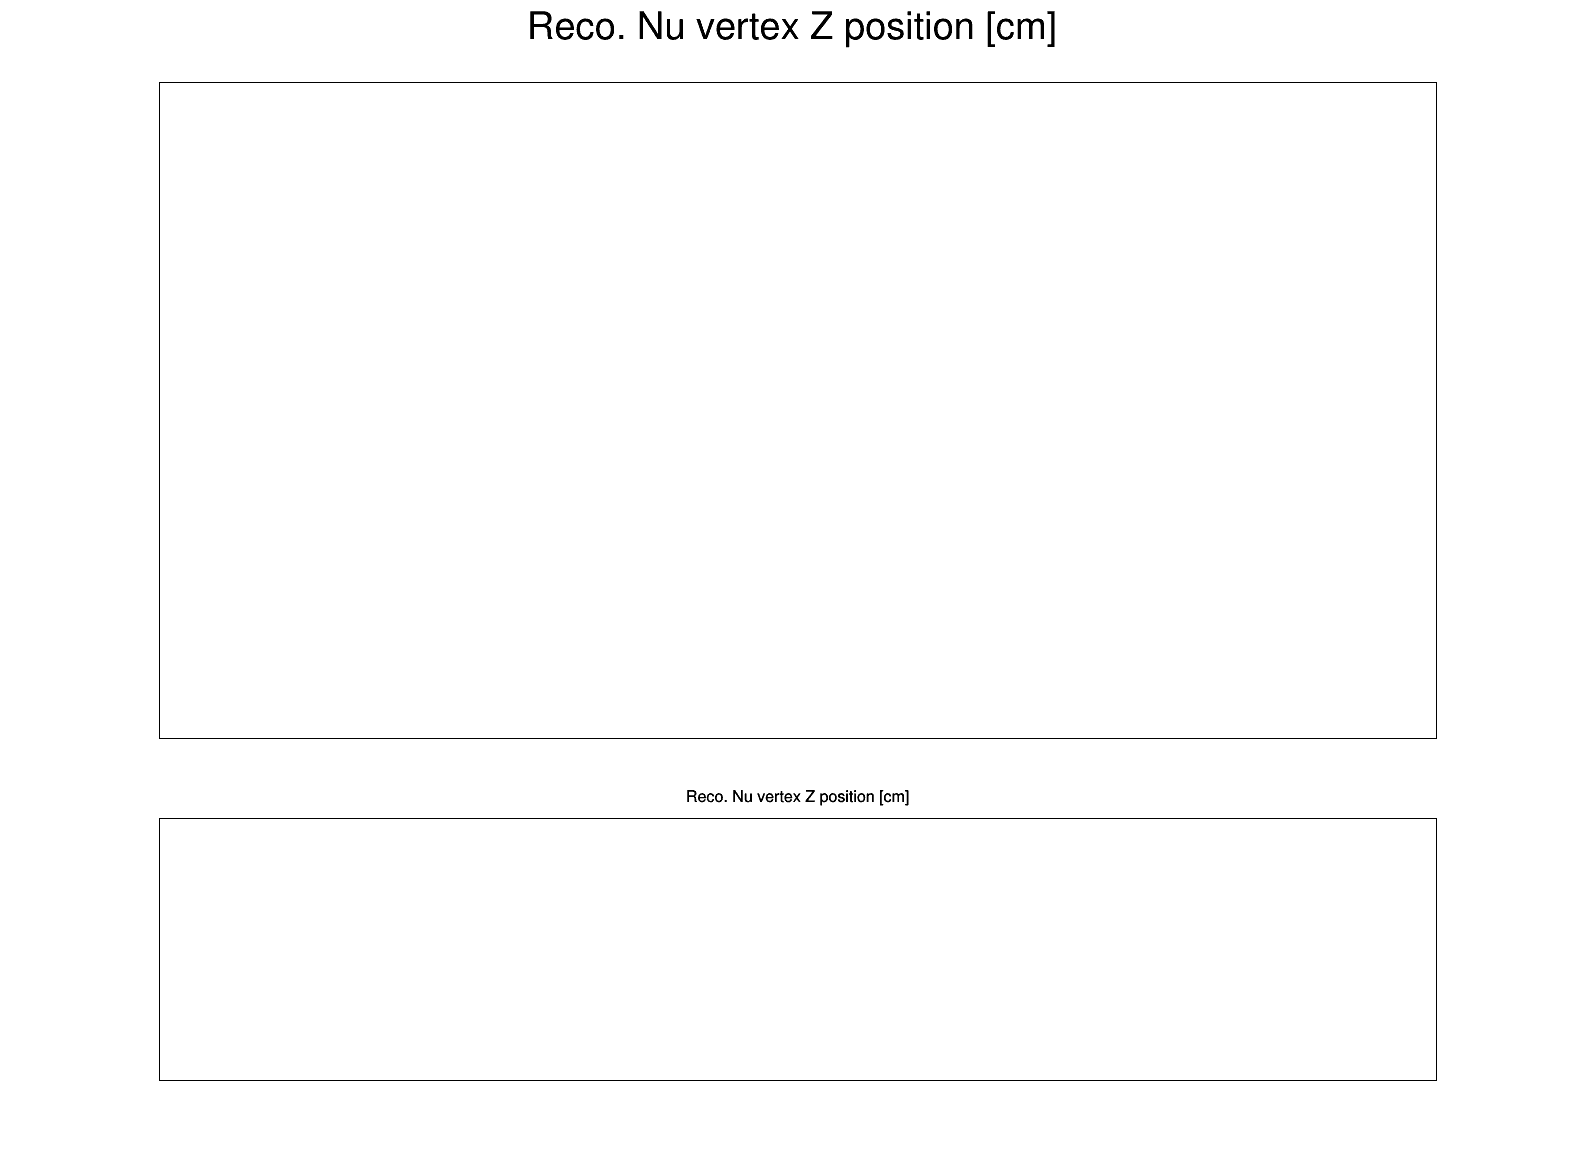

In [44]:
cut = 'fidVol && muon'
name = '_initial_V'
side_right = 'right'
side_left = 'left'
start = time.time()
NuCC_w.make_stacked_histo_weight_MCC8_V(cut,'Nu_Vx_sce','EventWeight','Reco. Nu vertex X position [cm]',-10,270,20,'NuVx_sce'+name,side_left)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8_V(cut,'Nu_Vy_sce','EventWeight','Reco. Nu vertex Y position [cm]',-120,120,20,'NuVy_sce'+name,side_left)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8_V(cut,'Nu_Vz_sce','EventWeight','Reco. Nu vertex Z position [cm]',-50,1050,20,'NuVz_sce'+name,side_left)
end = time.time()
print(end - start)

Normalization (data)/(mc +ext) =  0.977012724919
9.3889131546
Normalization (data)/(mc +ext) =  0.977012610301
19.1135389805
Normalization (data)/(mc +ext) =  0.977012762141
28.9097471237


Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/marco_weighted//png/NuVx_sce_muon_cut_V.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/marco_weighted//png/NuVx_sce_muon_cut_V.pdf has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/marco_weighted//root/NuVx_sce_muon_cut_V.root has been created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/marco_weighted//png/NuVy_sce_muon_cut_V.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/

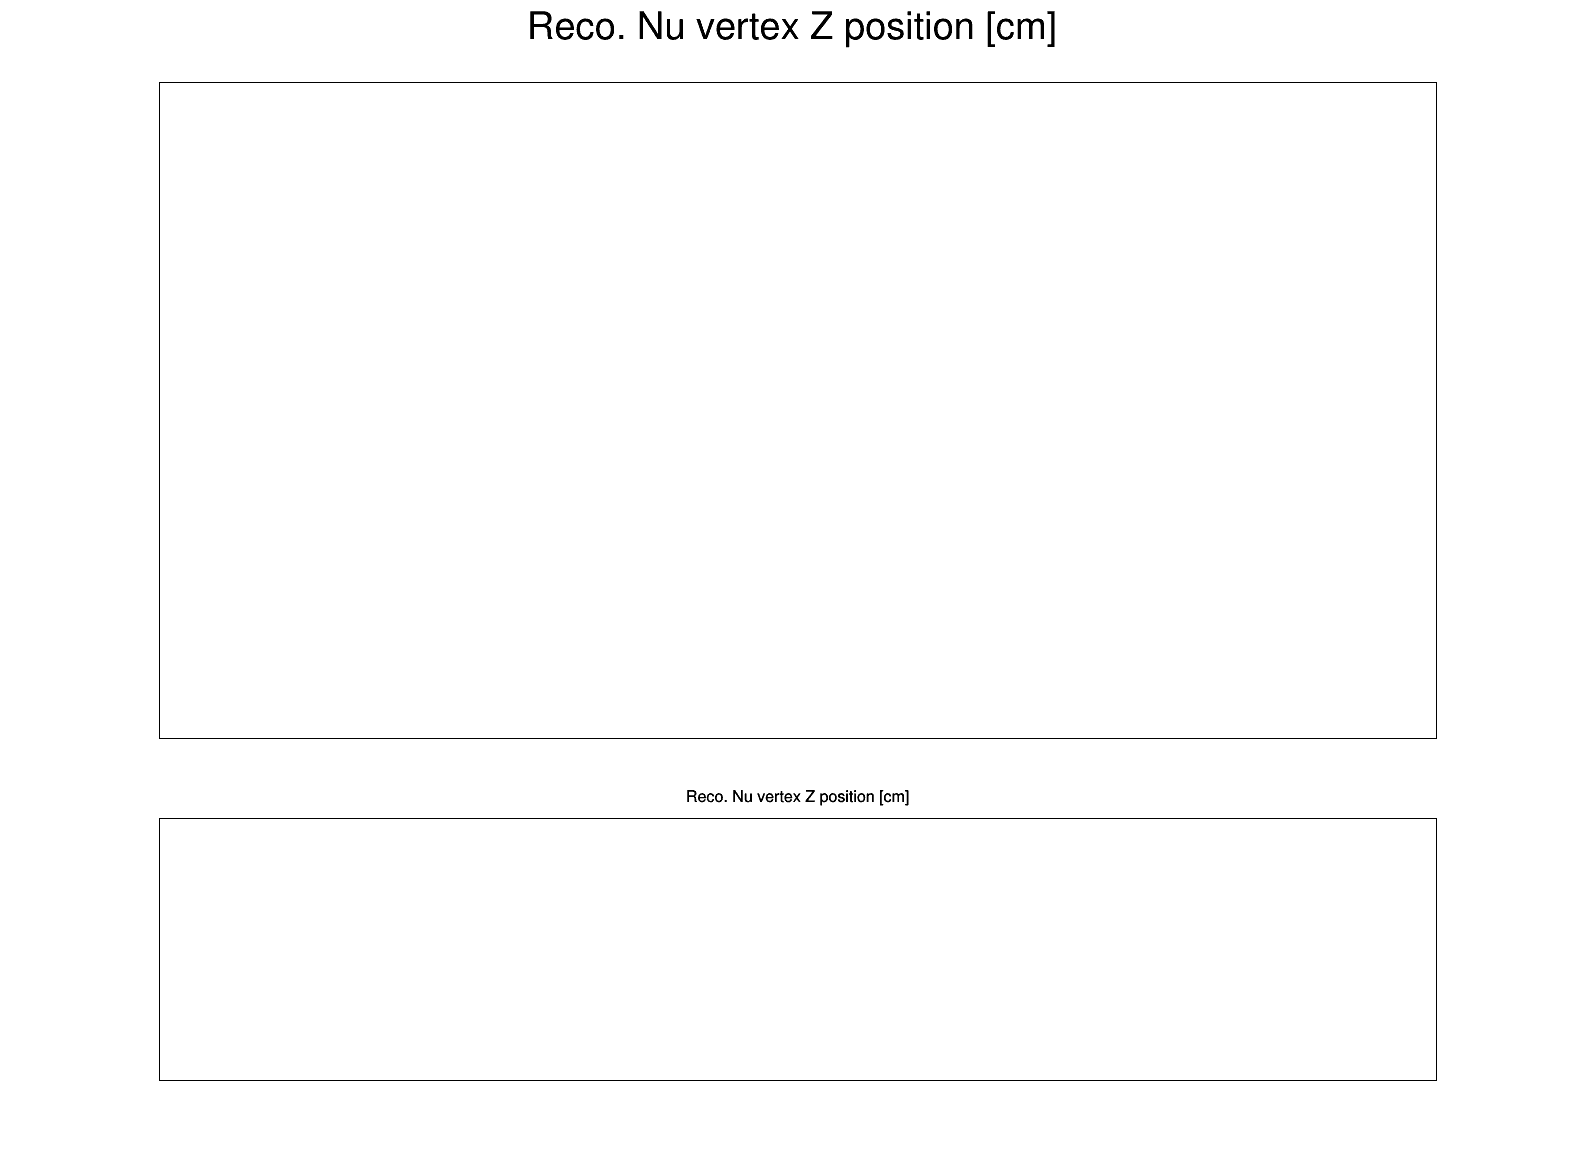

In [45]:
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
name = '_muon_cut_V'
side_right = 'right'
side_left = 'left'
start = time.time()
NuCC_w.make_stacked_histo_weight_MCC8_V(cut,'Nu_Vx_sce','EventWeight','Reco. Nu vertex X position [cm]',-10,270,20,'NuVx_sce'+name,side_left)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8_V(cut,'Nu_Vy_sce','EventWeight','Reco. Nu vertex Y position [cm]',-120,120,20,'NuVy_sce'+name,side_left)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8_V(cut,'Nu_Vz_sce','EventWeight','Reco. Nu vertex Z position [cm]',-50,1050,20,'NuVz_sce'+name,side_left)
end = time.time()
print(end - start)

In [ ]:
cut = 'fidVol && muon'
name = '_initial_noLegend'
side_right = 'none'
side_left = 'none'
start = time.time()
NuCC_w.make_stacked_histo_weight_MCC8(cut + ' && TrackTheta!=-9','cos(TrackTheta)','EventWeight','cos(theta)',-1,1,20,'costhetaw'+name,side_left)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut + ' && TrackTheta!=-9','TrackPhi','EventWeight','Track Phi',-3.141,3.141,20,'phi'+name,side_left)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut + ' && 1','TrackMomMCS_mom','EventWeight','TrackMomMCS_mom',0,1.5,20,'TrackMomMCS_mom'+name,side_right)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut,'Nu_Vx_sce','EventWeight','Reco. Nu vertex X position [cm]',-10,270,20,'NuVx_sce'+name,side_right)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut,'Nu_Vy_sce','EventWeight','Reco. Nu vertex Y position [cm]',-120,120,20,'NuVy_sce'+name,side_right)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut,'Nu_Vz_sce','EventWeight','Reco. Nu vertex Z position [cm]',-50,1050,20,'NuVz_sce'+name,side_right)
end = time.time()
print(end - start)

In [ ]:
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
name = '_muon_cut_noLegend'
start = time.time()
NuCC_w.make_stacked_histo_weight_MCC8(cut + ' && TrackTheta!=-9','cos(TrackTheta)','EventWeight','cos(theta)',-1,1,20,'costhetaw'+name,side_left)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut + ' && TrackTheta!=-9','TrackPhi','EventWeight','Track Phi',-3.141,3.141,20,'phi'+name,side_left)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut + ' && 1','TrackMomMCS_mom','EventWeight','TrackMomMCS_mom',0,1.5,20,'TrackMomMCS_mom'+name,side_right)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut,'Nu_Vx_sce','EventWeight','Reco. Nu vertex X position [cm]',-10,270,20,'NuVx_sce'+name,side_right)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut,'Nu_Vy_sce','EventWeight','Reco. Nu vertex Y position [cm]',-120,120,20,'NuVy_sce'+name,side_right)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut,'Nu_Vz_sce','EventWeight','Reco. Nu vertex Z position [cm]',-50,1050,20,'NuVz_sce'+name,side_right)
end = time.time()
print(end - start)

Normalization (data)/(mc +ext) =  1.08852743124
20.2001259327
Normalization (data)/(mc +ext) =  1.08930651037
39.8269209862
Normalization (data)/(mc +ext) =  1.09047468935


Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/marco_weighted//png/NuTracks_initial.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/marco_weighted//png/NuTracks_initial.pdf has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/marco_weighted//root/NuTracks_initial.root has been created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/marco_weighted//png/NumPfp_initial.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/marco

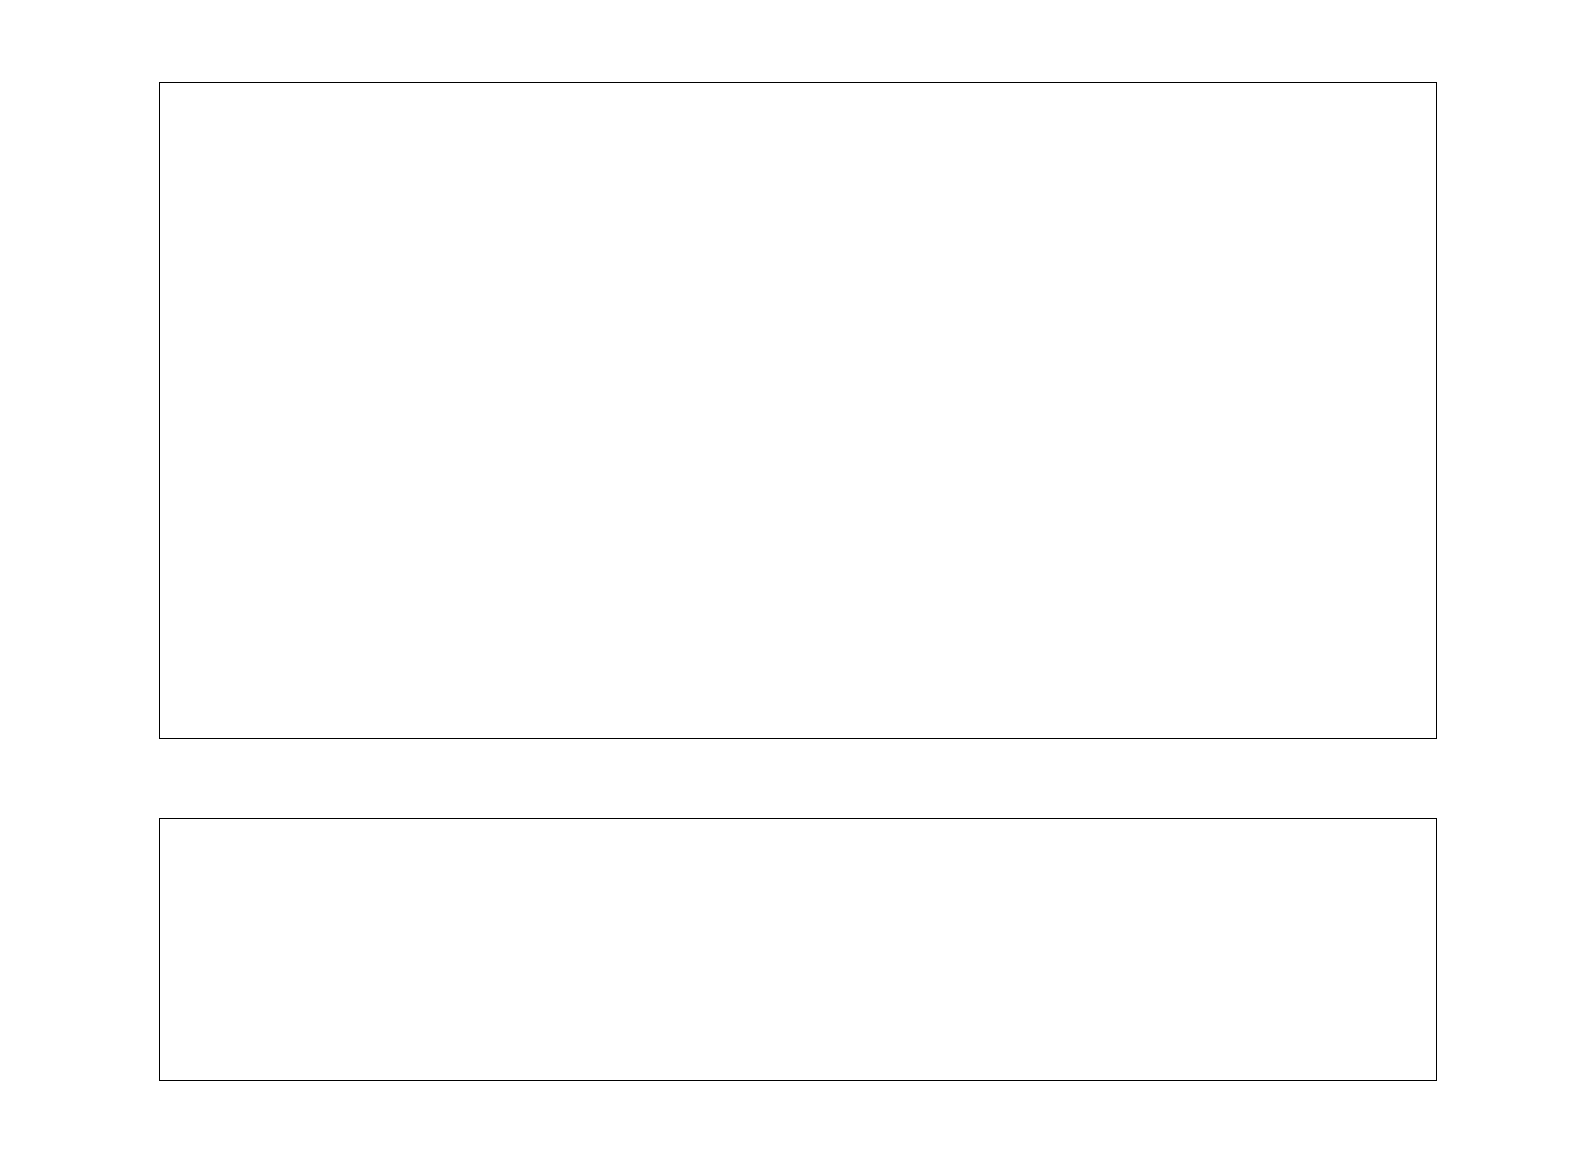

In [58]:
cut = 'fidVol && muon'
name = '_initial'
side_right = 'right'
side_left = 'left'
start = time.time()
NuCC_w.make_stacked_histo_weight_MCC8(cut + ' && 1','NuTracks','EventWeight','Number of Tracks',0,10,10,'NuTracks'+name,side_right)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut + ' && 1','NumPfp','EventWeight','Number of Pfparticle',0,10,10,'NumPfp'+name,side_right)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut + ' && 1','TrackLength','EventWeight','Track Length',0,700,20,'TrackLength'+name,side_right)
end = time.time()

Normalization (data)/(mc +ext) =  1.00411461581
50.3957400322
Normalization (data)/(mc +ext) =  1.00531721738
100.707967043
Normalization (data)/(mc +ext) =  1.00790259193


Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/marco_weighted//png/NuTracks_muon_cut.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/marco_weighted//png/NuTracks_muon_cut.pdf has been created
Info in <TCanvas::SaveAs>: ROOT file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/marco_weighted//root/NuTracks_muon_cut.root has been created
Warning in <TH1F::Sumw2>: Sum of squares of weights structure already created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Info in <TCanvas::Print>: png file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/marco_weighted//png/NumPfp_muon_cut.png has been created
Info in <TCanvas::Print>: pdf file /home/tmettler/Desktop/v08_00_00_33/V08_00_00_35/weighted/m

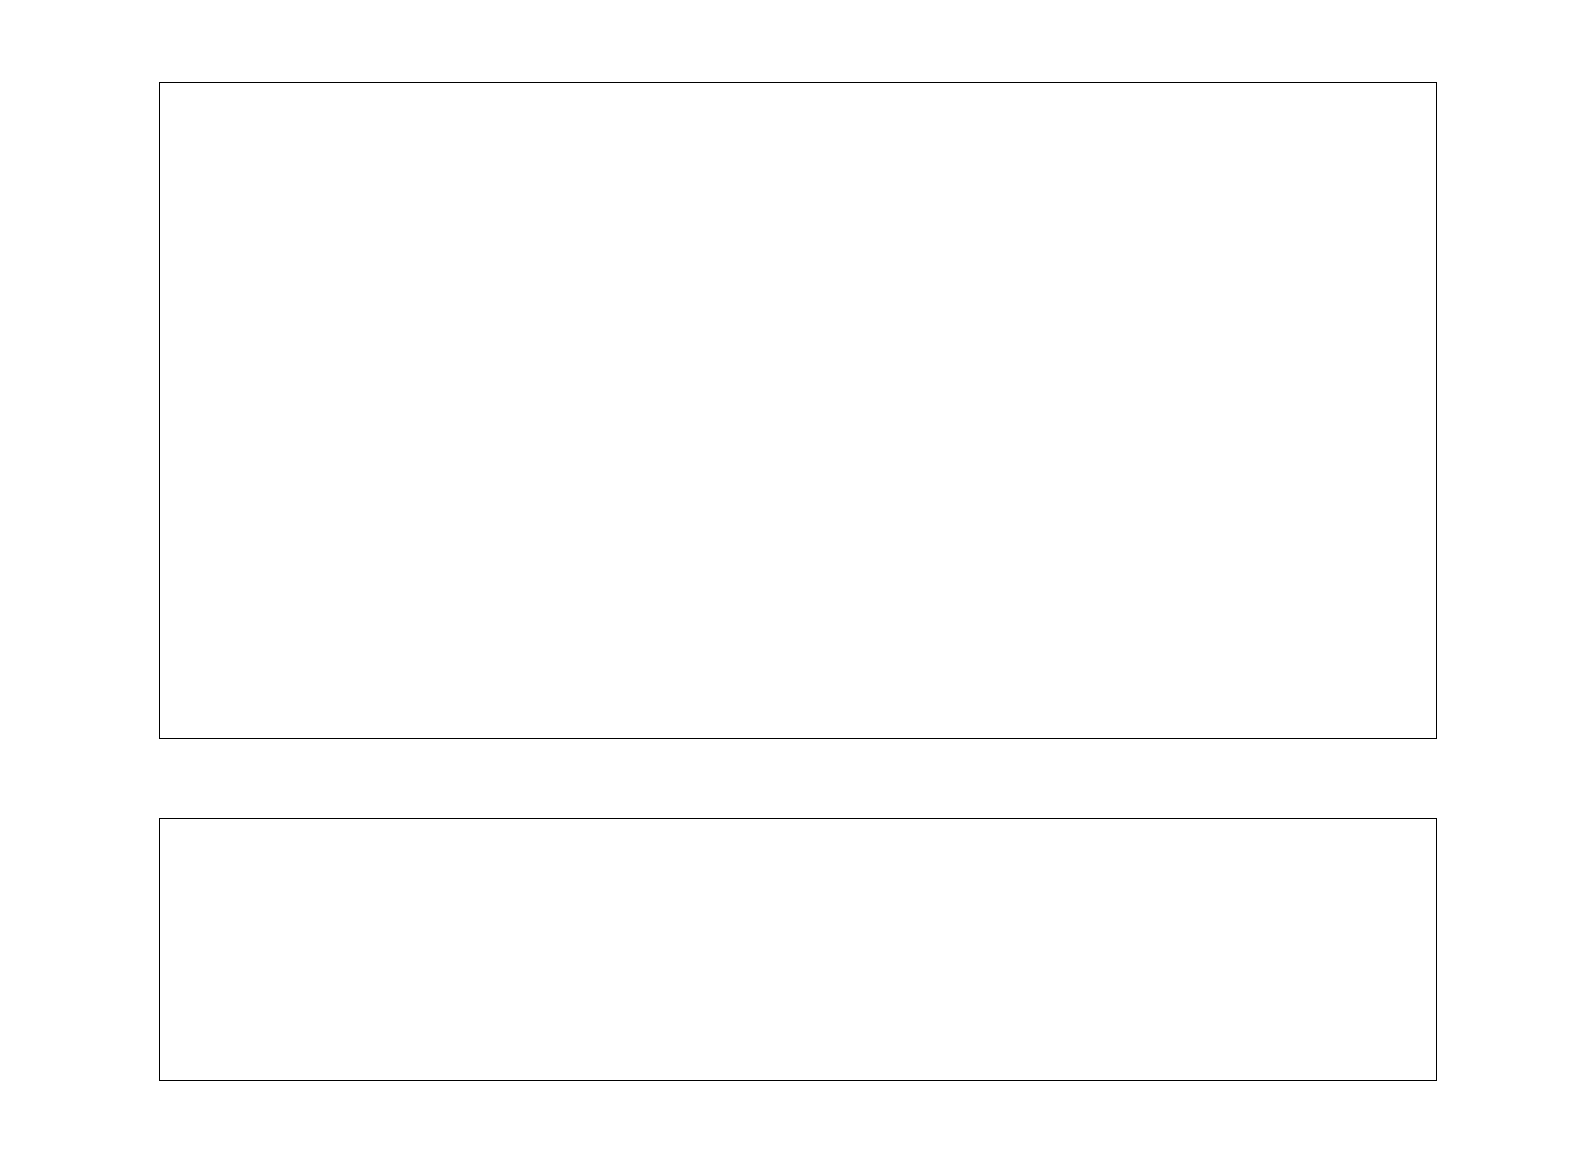

In [59]:
cut = 'fidVol && muon && TrackLength>8 && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
name = '_muon_cut'
side_right = 'right'
side_left = 'left'
start = time.time()
NuCC_w.make_stacked_histo_weight_MCC8(cut + ' && 1','NuTracks','EventWeight','Number of Tracks',0,10,10,'NuTracks'+name,side_right)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut + ' && 1','NumPfp','EventWeight','Number of Pfparticle',0,10,10,'NumPfp'+name,side_right)
end = time.time()
print(end - start)
NuCC_w.make_stacked_histo_weight_MCC8(cut + ' && 1','TrackLength','EventWeight','Track Length',0,700,20,'TrackLength'+name,side_right)
end = time.time()

In [ ]:
NuCC_w.printEff_w('fidVol && muon')

In [ ]:
NuCC_w.printEff_w('fidVol && muon && nr_crthit_top==0')

In [ ]:
NuCC_w.printEff_w('fidVol && muon && nr_crthit_top==0 && crthit_vertex_zcut==0')

In [ ]:
NuCC_w.printEff_w('fidVol && muon && nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0)')

In [ ]:
NuCC_w.printEff_w('fidVol && muon && nr_crthit_top==0 && crthit_vertex_zcut==0 && (track_end_uncontained==1 || nr_crthit_beam_tres==0) && crt_cut')

In [ ]:
NuCC_w.printEff_w('fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1')

In [ ]:
NuCC_w.printEff_w('fidVol && muon && crt_tom_cut')

In [ ]:
NuCC_w.printEff_w('fidVol && muon && crt_tom_cut && TrackScore>0.8')

In [ ]:
NuCC_w.printEff_w('fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20')

In [ ]:
NuCC_w.printEff_w('fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78')

In [ ]:
NuCC_w.printEff_w('fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1')

In [ ]:
nenner = 'numu_true'
zahler = 'fidVol && muon && numu_signal'
cut = 'fidVol && muon'
start = time.time()
NuCC_w.plot_eff_w(nenner,zahler,cut,'initial','initial')
end = time.time()
print(end - start)

In [ ]:
nenner = 'numu_true'
zahler = 'fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1 && numu_signal'
cut = 'fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
start = time.time()
NuCC_w.plot_eff_w(nenner,zahler,cut,'allcut','allcut')
end = time.time()
print(end - start)

In [ ]:
nenner = 'numu_signal && fidVol && muon'
zahler = 'fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1 && numu_signal'
cut = 'fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1'
start = time.time()
NuCC_w.plot_eff_w(nenner,zahler,cut,'tomcut_only','tomcut_only')
end = time.time()
print(end - start)

In [ ]:
nenner = 'numu_signal && fidVol && muon'
zahler = 'fidVol && muon && crt_tom_cut && numu_signal'
cut = 'fidVol && muon && crt_tom_cut'
start = time.time()
NuCC_w.plot_eff_w(nenner,zahler,cut,'crtcut_only','crtcut_only')
end = time.time()
print(end - start)

In [ ]:
NuCC_w.pdg_content33_w('fidVol && muon')

In [ ]:
NuCC_w.pdg_content33_w('fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1')

In [ ]:
NuCC_w.pdg_content33_w('fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1 && MCTrackPurity>0.5')

In [ ]:
NuCC_w.pdg_content33_w('fidVol && muon && crt_tom_cut && TrackScore>0.8\
                && TrackLength>20 && TrackPID_chiproton>78 && NuScore>0.1 && MCTrackPurity>0.5 && num_mc_muon>0')

In [ ]:
# initialte ROOT default canvas
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("c1","c1",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

In [ ]:
value = 'TrackLength'
xbins = 30
xstart = 0
xend = 30
step = (xend-xstart)/xbins
title = 'Track length [cm]'

h_eff =  ROOT.TH1F("h_eff",title,xbins,xstart,xend)
h_pur = ROOT.TH1F("h_pur",title,xbins,xstart,xend)
h_effpur = ROOT.TH1F("h_effpur",title,xbins,xstart,xend)
for i in range(xbins): 
    cut = 'muon && fidVol && TrackPID_chimuon<30 && NuScore>0.1 && crt_tom_cut && TrackScore>0.8 && ('+value+'>('+str(xstart)+'+'+str(step)+'*'+str(i)+'))'
    #print cut
    pur = overlay_out.GetEntries(cut+' && numu_signal')*scale[overlay]*100.0/(NuCC.getTotNum_out(cut)+0.00001)
    eff = overlay_out.GetEntries(cut+' && numu_signal')*100.0/overlay_out.GetEntries("numu_true")
    h_eff.SetBinContent(i+1,eff)
    h_pur.SetBinContent(i+1,pur)
    h_effpur.SetBinContent(i+1,eff*pur/100.0)
    #print eff ,pur, eff*pur,i

legend = ROOT.TLegend(0.15,0.75,0.48,0.9);
legend.AddEntry(h_eff,"efficiency","f");
legend.AddEntry(h_pur,"purity","f");
legend.AddEntry(h_effpur,"eff * pur","f");

h_eff.SetLineColor(1)
h_eff.SetMaximum(100)
h_eff.SetMinimum(0)
h_pur.SetLineColor(2)
h_effpur.SetLineColor(3)
h_pur.SetLineWidth(3)
h_eff.SetLineWidth(3)
h_effpur.SetLineWidth(3)
h_eff.Draw()
legend.Draw()
h_pur.Draw('same')
h_effpur.Draw('same')
h_eff.Draw('same')
c1.SetLogy(0)
c1.Draw()
c1.SaveAs(outputdir_png+ value +".png");
c1.SaveAs(outputdir_root+ value+ ".root");

print 'Variation of cut on: '+value
print 'Maximum value: ', h_effpur.GetMaximum()
print 'Bin: ', h_effpur.GetMaximumBin(),' -> Value: ', xstart+(h_effpur.GetMaximumBin()-1)*step

In [ ]:
value = 'TrackPID_chimuon'
xbins = 30
xstart = 0
xend = 30
step = (xend-xstart)/xbins
title = 'Track PID chi square'

h_eff =  ROOT.TH1F("h_eff",title,xbins,xstart,xend)
h_pur = ROOT.TH1F("h_pur",title,xbins,xstart,xend)
h_effpur = ROOT.TH1F("h_effpur",title,xbins,xstart,xend)
for i in range(xbins): 
    cut = 'muon && fidVol && crt_tom_cut && TrackScore>0.8 && \
        TrackLength>20 && NuScore>0.1 && ('+value+'<('+str(xstart)+'+'+str(step)+'*'+str(i)+'))'
    #print cut
    pur = overlay_out.GetEntries(cut+' && numu_signal')*scale[overlay]*100.0/(NuCC.getTotNum_out(cut)+0.00001)
    eff = overlay_out.GetEntries(cut+' && numu_signal')*100.0/overlay_out.GetEntries("numu_true")
    h_eff.SetBinContent(i+1,eff)
    h_pur.SetBinContent(i+1,pur)
    h_effpur.SetBinContent(i+1,eff*pur/100.0)
    #print eff ,pur, eff*pur,i

legend = ROOT.TLegend(0.15,0.75,0.48,0.9);
legend.AddEntry(h_eff,"efficiency","f");
legend.AddEntry(h_pur,"purity","f");
legend.AddEntry(h_effpur,"eff * pur","f");

h_eff.SetLineColor(1)
h_eff.SetMaximum(100)
h_eff.SetMinimum(0)
h_pur.SetLineColor(2)
h_effpur.SetLineColor(3)
h_pur.SetLineWidth(3)
h_eff.SetLineWidth(3)
h_effpur.SetLineWidth(3)
h_eff.Draw()
legend.Draw()
h_pur.Draw('same')
h_effpur.Draw('same')
h_eff.Draw('same')
c1.SetLogy(0)
c1.Draw()
c1.SaveAs(outputdir_png+ value +".png");
c1.SaveAs(outputdir_root+ value+ ".root");

print 'Variation of cut on: '+value
print 'Maximum value: ', h_effpur.GetMaximum()
print 'Bin: ', h_effpur.GetMaximumBin(),' -> Value: ', xstart+(h_effpur.GetMaximumBin()-1)*step

In [ ]:
value = 'NuScore'
xbins = 20
xstart = 0
xend = 0.5
step = (xend-xstart)/xbins
title = 'Track length [cm]'

h_eff =  ROOT.TH1F("h_eff",title,xbins,xstart,xend)
h_pur = ROOT.TH1F("h_pur",title,xbins,xstart,xend)
h_effpur = ROOT.TH1F("h_effpur",title,xbins,xstart,xend)
for i in range(xbins): 
    cut = 'muon && fidVol && crt_tom_cut && TrackScore>0.8 && ('+value+'>('+str(xstart)+'+'+str(step)+'*'+str(i)+'))'
    #print cut
    pur = overlay_out.GetEntries(cut+' && numu_signal')*scale[overlay]*100.0/(NuCC.getTotNum_out(cut)+0.00001)
    eff = overlay_out.GetEntries(cut+' && numu_signal')*100.0/overlay_out.GetEntries("numu_true")
    h_eff.SetBinContent(i+1,eff)
    h_pur.SetBinContent(i+1,pur)
    h_effpur.SetBinContent(i+1,eff*pur/100.0)
    #print eff ,pur, eff*pur,i

legend = ROOT.TLegend(0.15,0.75,0.48,0.9);
legend.AddEntry(h_eff,"efficiency","f");
legend.AddEntry(h_pur,"purity","f");
legend.AddEntry(h_effpur,"eff * pur","f");

h_eff.SetLineColor(1)
h_eff.SetMaximum(100)
h_eff.SetMinimum(0)
h_pur.SetLineColor(2)
h_effpur.SetLineColor(3)
h_pur.SetLineWidth(3)
h_eff.SetLineWidth(3)
h_effpur.SetLineWidth(3)
h_eff.Draw()
legend.Draw()
h_pur.Draw('same')
h_effpur.Draw('same')
h_eff.Draw('same')
c1.SetLogy(0)
c1.Draw()
c1.SaveAs(outputdir_png+ value +".png");
c1.SaveAs(outputdir_root+ value+ ".root");

print 'Variation of cut on: '+value
print 'Maximum value: ', h_effpur.GetMaximum()
print 'Bin: ', h_effpur.GetMaximumBin(),' -> Value: ', xstart+(h_effpur.GetMaximumBin()-1)*step